# Carbonfact - Named Entity Recognition & Relation Extraction

In [1]:
# Author Michel DEUDON

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
sys.path.insert(0, os.path.dirname("../src"))

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Prepare data

In [5]:
from src.dataloader import fetch_data
inputs, targets, materials = fetch_data()
assert len(inputs) == len(targets)

In [6]:
# split dataset into training and testing set
from sklearn.model_selection import train_test_split
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1, random_state=42)
print("Collected {} training examples and {} testing examples".format(len(inputs_train), len(inputs_test)))

Collected 540 training examples and 60 testing examples


In [7]:
print("INPUT ", inputs_train[0])
print("LABEL ", targets_train[0])

INPUT  49%polyamide,45%polyester,6%elastane
LABEL  {'': [{'material': 'polyamide', 'proportion': 49.0}, {'material': 'polyester', 'proportion': 45.0}, {'material': 'elastane', 'proportion': 6.0}]}


## 1.1 Domain knowledge

### 1.1.1 Clothing components

In [8]:
all_components = np.sort(list(set([v for u in targets_train for v in list(u.keys()) if v!=''])))
all_components[:4]

array(['ank', 'aol', 'back_panel', 'body'], dtype='<U22')

### 1.1.2 Clothing materials

In [9]:
all_materials = np.sort([w for w in list(set(materials)) if w!=''])
all_materials[:4]

array(['acrylic', 'acrylique', 'bamboo', 'cotton'], dtype='<U18')

### 1.1.3 Preprocessing function

In [10]:
def preprocess(text):
    """ Abbreviate text (reduce dimensionality, keep info), e.g., Polyamide --> plymd """
    
    text = text.lower()
    for c in text:
        if c not in ' %0123456789&:;,-bcdfghklmnpqrstvwxy': # keep non vowels (except y)
            text = text.replace(c, '')
    return text

In [11]:
# verify preprocessing no collisions
assert len(all_components) == len(set([preprocess(u) for u in all_components]))
assert len(all_materials) == len(set([preprocess(u) for u in all_materials]))
assert len(all_components)+len(all_materials) == len(set([preprocess(u) for u in all_components]+[preprocess(u) for u in all_materials]))

In [12]:
# preprocess all_materials and components
all_materials_p = [preprocess(w) for w in all_materials]
all_components_p = [preprocess(w.replace("_", " ")) for w in all_components]

In [13]:
# from low to high dimension
reverse_mapping_materials = dict(zip(all_materials_p, all_materials))
reverse_mapping_components = dict(zip(all_components_p, all_components))

In [14]:
print("ORIGINAL   ", inputs_train[4])
print("ABBREVIATED", preprocess(inputs_train[4]))

ORIGINAL    micro - 80% polyamide 20% elastane/mesh - 84% polyamide 16% elastane
ABBREVIATED mcr - 80% plymd 20% lstnmsh - 84% plymd 16% lstn


# 2. Train language model

## 2.2 Initialize/fit HMM model prior

### 2.2.1 Hidden states transitions' parameters

In [15]:
# Bernoulli or Gaussian HMM with 4 hidden states
states = ["component", "material", "proportion", "other"]

In [16]:
def init_start_probs_trans_mat(targets, eps = 0.0001):
    ''' Markov Chain start_probs (n_hidden) and transition probability matrix (n_hidden, n_hidden) '''
    
    start_probs = np.zeros(4) # component, material, proportion, other
    trans_mat = np.zeros((4,4)) # transition probabilities between hidden state

    for t in targets:
        for k,v in t.items():

            # inspect components k
            if k=="" and len(t.keys())==1:
                start_probs[2] +=1 # start with proportion
            else:
                start_probs[0] +=1 # start with component
                trans_mat[0][0] +=len(k) # len of component (ex: lace)
                trans_mat[0][1] += 0.3
                trans_mat[0][2] += 0.3
                trans_mat[0][3] += 0.3

            # inspect proportions / materials
            for w in v:
                trans_mat[1][1] += len(w["material"]) # len of material (ex: nylon)
                trans_mat[1][0] += 1
                trans_mat[1][2] += 1
                trans_mat[1][3] += 1

                trans_mat[2][2] += 3 # len of proportions (ex: 80%)
                trans_mat[2][0] += 0.3
                trans_mat[2][1] += 0.3
                trans_mat[2][3] += 0.3
    
    # smooth & normalize probabilities
    start_probs = start_probs + eps
    start_probs = start_probs / start_probs.sum()
    trans_mat = trans_mat + eps
    trans_mat = trans_mat/np.sum(trans_mat, axis=1, keepdims=True)
    
    return start_probs, trans_mat

### 2.2.2 Emission model parameters

In [17]:
alphabet = np.sort(list(set([c for s in inputs for c in preprocess(s)])))
charlist = "".join(alphabet) # All observed emissions
charlist 

' %&,-0123456789:;bcdfghklmnpqrstvwxy'

In [18]:
def vectorize(lexic, eps=0.0001):
    """ Calculate emission probs (character statistics) from lexic (list of keywords)"""
    
    alphabet, counts = np.unique([c for w in lexic for c in w], return_counts=True)
    v = np.zeros(len(charlist))
    for i,c in enumerate(charlist):
        if c in alphabet:
            idx, = np.where(alphabet==c)
            v[i] = counts[idx[0]]

    v = v + eps
    v = v / v.sum()
    return v

In [19]:
def init_emission_probs(eps = 0.0001):
    ''' Emission probability matrix (n_hidden, n_observed) '''
    
    emission_probs = np.zeros((len(states),len(charlist)))

    # set state emissions from observations
    emission_probs[0] = vectorize(lexic=all_components) # component char emissions
    emission_probs[1] = vectorize(lexic=all_materials) # material char emissions
    emission_probs[2] = vectorize(lexic=["0123456789% "]) # proportion
    emission_probs[3] = vectorize(lexic=["-&,:; "]) # other
    
    # smooth proba & normalize probabilities
    emission_probs = emission_probs + eps
    emission_probs = emission_probs/np.sum(emission_probs, axis=1, keepdims=True)
    
    return emission_probs

In [20]:
start_probs, trans_mat = init_start_probs_trans_mat(targets_train)
emission_probs = init_emission_probs()

## 2.3 Visualize model

In [21]:
#from src.hmm import plot_parameters
#plot_parameters(states, trans_mat, emission_probs)

# 3. Extract entities from hidden states (NER)

Goal: Given a string, extract its components, materials, proportions

In [22]:
from src.hmm import viterbi

In [23]:
char2id = dict(zip(charlist,np.arange(len(charlist))))

In [24]:
def NER(text):
    ''' Extract entities from text with HMM and maximum a posteriori (Viterbi algorithm) '''
    
    ps = preprocess(text)
    obs = [char2id[c] for c in ps]
    #print(text)
    #print(ps)

    from collections import OrderedDict
    all_position = []
    labels = OrderedDict()

    hidden_seq = viterbi(obs, states, emission_probs, trans_mat) # predict hidden states sequence
    hidden_seq = np.array(hidden_seq)
    for s in states:
        positions, = np.where(hidden_seq==s)
        diff = positions[1:]-positions[:-1]
        positions = [p for i,p in enumerate(positions) if i==0 or diff[i-1]>1]
        n = len(positions) # number of instances of state in text
        if n > 0:
            for p in positions:
                labels[p] = s
            all_position += positions


    breaks = np.sort(all_position)
    result = []
    for i in range(len(breaks)-1):
        start,stop = breaks[i],breaks[i+1]
        if labels[start] != 'other':
            result.append( (ps[start:stop],labels[start],start,stop) )

    if len(breaks)>0:
        result.append( (ps[stop:],labels[stop],stop,len(ps)) )
    return result

In [25]:
def clean_NER(result):
    ''' Ensure NER in all_components or all_materials '''
    
    new_result = []
    for u in result:
        substring = u[0].strip()
        if substring in all_components_p:
            new_result.append((substring, "component"))
        elif substring in all_materials_p:
            new_result.append((substring, "material"))
        else:
            new_result.append((substring, u[1]))
    return new_result

In [26]:
#result = NER(inputs_train[0])
#result

In [27]:
#new_result = clean_NER(result)
#new_result

# 4. Extract relationships from entities

In [28]:
def p2f(x):
    ''' Utility: Percentage to float (for proportions)'''
    try:
        return float(x.strip('%'))
    except:
        return x

In [29]:
def extract_relations(text):
    """ Extract relations: clothe <> component <> materials <> proportion """
    
    entities = NER(text)
    entities = clean_NER(entities)

    relation = {}
    last_component = ""
    current_part = {'material': "", 'proportion': 0.0}
    flag = False
    for text, label in entities:
        if label == "component":
            if text in reverse_mapping_components:
                last_component = reverse_mapping_components[text]
            else:
                last_component = text
                flag = True # warning component not recognized
        elif label == "material":
            if text in reverse_mapping_materials:
                current_part["material"] = reverse_mapping_materials[text]
            else:
                current_part["material"] = text 
                flag = True # warning material not recognized
        elif label == "proportion":
            current_part["proportion"] = p2f(text)

        if current_part["material"] != "" and current_part['proportion'] != 0.0:
            if last_component not in relation:
                relation[last_component] = []
            relation[last_component].append(current_part)
            current_part = {'material': "", 'proportion': 0.0}
            
    return relation, flag

In [30]:
#i = 10
#text = inputs_train[i]
#label = targets_train[i]
#relation, flag = extract_relations(text)

#print(text)
#print("Warning:", flag)
#print("Assert:", label == relation, '\n')

#print(label, '\n')
#print(relation)

# 5. Eval

In [31]:
def score_model(inputs, targets):
    ''' Calculate model accuracy and warnings'''

    warnings = 0
    accurate = 0
    outputs = []
    for i in range(len(inputs)):
        text = inputs[i]
        label = targets[i]
        relation, flag = extract_relations(text)
        warnings += int(flag)
        accurate += int(label == relation)
        outputs.append(relation)
        
        # verify components' compositions sum to 100 (otherwise raise flag, if not already raised)
        p_sums = [np.sum([part["proportion"] for part in component]) for component in relation.values()]
        if set(p_sums) != set([100.0]) and int(flag) == 0:
            warnings += 1
    metrics = {"warnings": warnings, "accurate":accurate}
    return outputs, metrics

In [32]:
# eval model training/testing set (accuracy)
outputs_train, metrics_train = score_model(inputs_train, targets_train)
outputs_test, metrics_test = score_model(inputs_test, targets_test)
print("Train accuracy {:.1f}".format(100*metrics_train["accurate"]/len(inputs_train)))
print("Test accuracy {:.1f}".format(100*metrics_test["accurate"]/len(inputs_test)))

Train accuracy 76.7
Test accuracy 76.7


In [33]:
# eval model training/testing set (predicted errors: component/material not recognized or proportions do not sum to 100)
print("Train warnings {:.1f}".format(100*metrics_train["warnings"]/len(inputs_train)))
print("Test warnings {:.1f}".format(100*metrics_test["warnings"]/len(inputs_test)))

Train warnings 23.0
Test warnings 23.3


## 5.2. Distributions and biases

In [34]:
def plot_components_distr(output, title="", ylim=12):
    lol = [list(row.keys()) for row in output]
    distr = np.sort([w for s in lol for w in s if w!=''])
    x_labels = np.unique(distr)
    plt.hist(distr, color="black")
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)
    plt.ylim(0,ylim)
    plt.title(title)

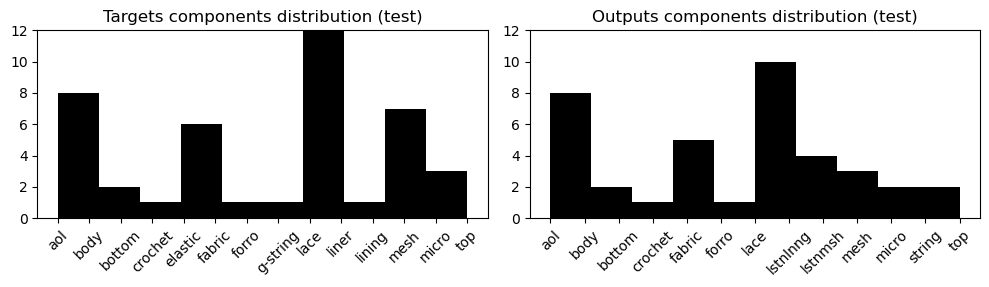

In [35]:
# plot components distribution (targets vs. outputs on test split)
plt.figure(1, figsize=(10, 5))
plt.subplot(221)
plot_components_distr(targets_test, title="Targets components distribution (test)", ylim=12)
plt.subplot(222)
plot_components_distr(outputs_test, title="Outputs components distribution (test)", ylim=12)
plt.tight_layout()
plt.show()

In [36]:
def plot_components_materials_heatmap(output, title="", vmax=500, eps=0.0000001):
    
    # convert output to a dictionary components --> materials: proportions (sum)
    tmp_dict = {}
    for component in all_components:
        tmp_dict[component] = {}
    for row in output:
        for component, composition in row.items():
            if component != '' and component in all_components:
                for c in composition:
                    if c["material"] in all_materials:
                        if c["material"] in tmp_dict[component]:
                            tmp_dict[component][c["material"]] += c["proportion"]
                        else:
                            tmp_dict[component][c["material"]] = c["proportion"]
                            
    # convert dictionary to heatmap
    heatmap = np.zeros((len(all_components), len(all_materials)))
    for i, c in enumerate(all_components):
        for j, m in enumerate(all_materials):
            if c in tmp_dict:
                if m in tmp_dict[c]:
                    heatmap[i][j] = tmp_dict[c][m]
                    
    # normalize data (each row/components sums to 100)
    heatmap = 100*heatmap / (heatmap.sum(axis=1, keepdims=True)+eps)
    
    # plot heatmap
    plt.imshow(heatmap, cmap="binary", vmin=0, vmax=vmax, aspect='auto')
    plt.xticks(np.arange(len(all_materials)), all_materials, rotation=90)
    plt.yticks(np.arange(len(all_components)), all_components)
    plt.title(title)

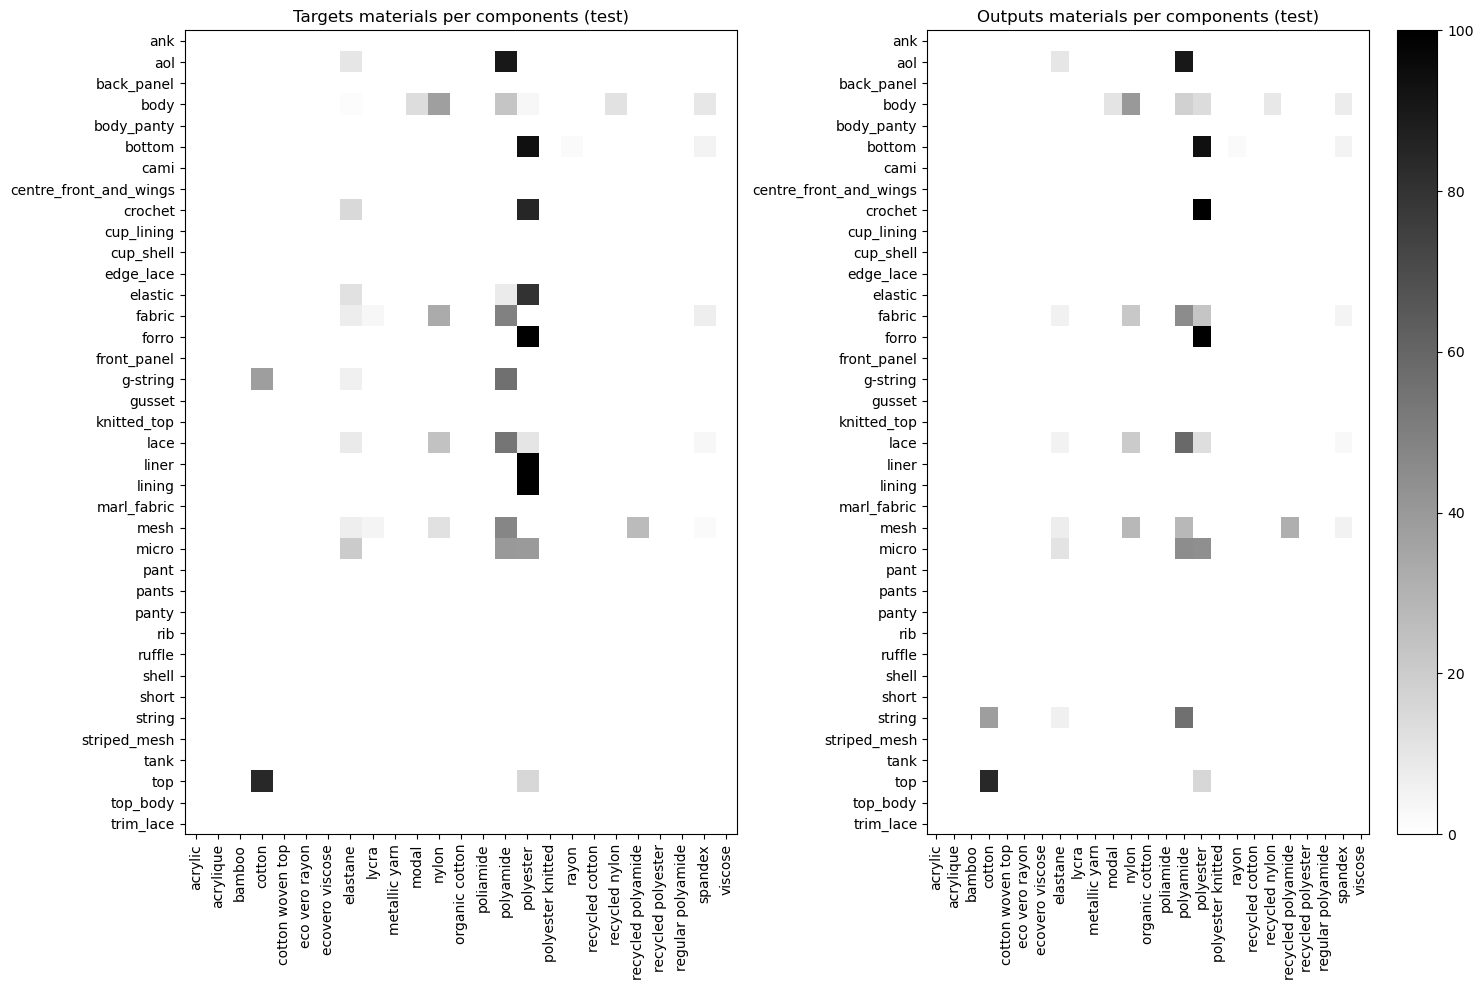

In [37]:
# plot materials per components heatmap
plt.figure(1, figsize=(15, 10))
plt.subplot(121)
plot_components_materials_heatmap(targets_test, title="Targets materials per components (test)", vmax=100)
plt.subplot(122)
plot_components_materials_heatmap(outputs_test, title="Outputs materials per components (test)", vmax=100)
plt.colorbar()
plt.tight_layout()
plt.show()

In [38]:
# TO GO FURTHER 
### Inspect errors and warnings
### Fine tune model on inputs (maximum likelihood, EM algorithm)
### Augment data with noise (insert/delete/replace char)
### Extend model: From unigrams to ngrams, tfidf, LDA/NMF/pLSI, Gaussian HMM...